In [1]:
# https://www.kaggle.com/code/oluwatobiojekanmi/transfer-learning-covid-19-cxr-classification
# https://www.kaggle.com/code/tranlamhuy/pnemonia-detection-resnet-and-inception-tensorflow
# ---------------------------------1 - Import các thư viện cần thiết -----------------------
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC


In [28]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

In [50]:
# ----------------------------------2 --Sử dụng ImageDataGenerator để tạo dữ liệu huấn luyện --------------
batch_size = 32
img_size = (224, 224)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    'D:/input/',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    'D:/input/',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)
test_generator = val_datagen.flow_from_directory(
    'D:/input/',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)



Found 1800 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


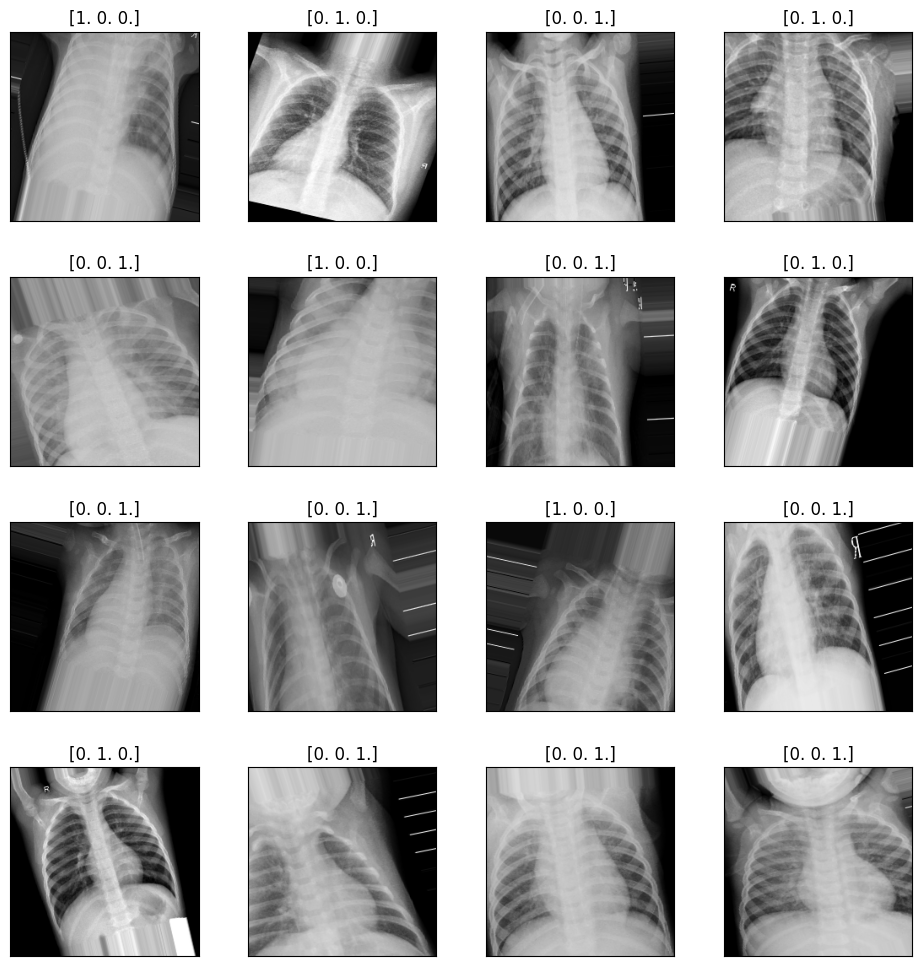

In [57]:
# lấy ra một batch ảnh từ generator
x_batch, y_batch = next(train_generator)

# tính toán số lượng subplot cần tạo
num_subplots = min(len(x_batch), 32)

# hiển thị các ảnh trong batch
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12),
                         subplot_kw={'xticks': [], 'yticks': []},
                         gridspec_kw=dict(hspace=0.3, wspace=0.1))
for i, ax in enumerate(axes.flat):
    if i < num_subplots:
        ax.imshow(x_batch[i])
        ax.set_title(y_batch[i])
plt.show()


In [5]:
# --------------------------3---Tạo mô hình MobileNetV2---------------------------
import tensorflow as tf
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)

# Xây dựng mô hình hoàn chỉnh
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [6]:
# -------------------------------------4----Huấn luyện với mô hình MobileNetV2------------------------------------
optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
)
# Đánh giá mô hình trên tập dữ liệu kiểm định
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)


Epoch 1/10
57/57 [==============================] - 67s 1s/step - loss: 1.1653 - accuracy: 0.3533 - val_loss: 1.0770 - val_accuracy: 0.4150
Epoch 2/10
57/57 [==============================] - 123s 2s/step - loss: 1.0445 - accuracy: 0.4400 - val_loss: 0.9874 - val_accuracy: 0.5117
Epoch 3/10
57/57 [==============================] - 138s 2s/step - loss: 0.9559 - accuracy: 0.5344 - val_loss: 0.9069 - val_accuracy: 0.5717
Epoch 4/10
57/57 [==============================] - 128s 2s/step - loss: 0.8928 - accuracy: 0.5711 - val_loss: 0.8380 - val_accuracy: 0.6217
Epoch 5/10
57/57 [==============================] - 85s 1s/step - loss: 0.8379 - accuracy: 0.6178 - val_loss: 0.8003 - val_accuracy: 0.6267
Epoch 6/10
57/57 [==============================] - 141s 2s/step - loss: 0.7919 - accuracy: 0.6444 - val_loss: 0.7585 - val_accuracy: 0.6850
Epoch 7/10
57/57 [==============================] - 141s 2s/step - loss: 0.7629 - accuracy: 0.6728 - val_loss: 0.7477 - val_accuracy: 0.6917
Epoch 8/10
57/5

In [19]:
# Lấy các dự đoán từ tập dữ liệu huấn luyện và kiểm định
train_features = model.predict_generator(train_generator)
val_features = model.predict_generator(val_generator)

# Trích xuất nhãn từ các tập dữ liệu huấn luyện và kiểm định
train_labels = train_generator.classes
val_labels = val_generator.classes

# Huấn luyện SVM trên các đặc trưng được trích xuất từ mô hình
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(train_features, train_labels)

# Đánh giá SVM trên tập dữ liệu kiểm định
test_features = model.predict_generator(test_generator)
test_labels = test_generator.classes
test_acc = svm.score(test_features, test_labels)
print('Test accuracy:', test_acc)


C:\Users\Admin\AppData\Local\Temp\ipykernel_43912\754749432.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_features = model.predict_generator(train_generator)
C:\Users\Admin\AppData\Local\Temp\ipykernel_43912\754749432.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  val_features = model.predict_generator(val_generator)
C:\Users\Admin\AppData\Local\Temp\ipykernel_43912\754749432.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_features = model.predict_generator(test_generator)


Test accuracy: 0.32666666666666666


In [24]:
from keras.preprocessing import image
import numpy as np

# -------------------7 -------Sử dụng mô hình đã huấn luyện để dự đoán loại của 1 ảnh mới -------
img_path = 'D:/input/bacterial/person10_bacteria_43.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.
# ---------------------8----Hiển thị kết quả------------------------
feature = base_model.predict(img_array)
prediction = svm.predict(feature)[0]
# In ra lớp của ảnh X-ray dự đoán được
if prediction == 0:
    print("Bacterial")
elif prediction == 1:
    print("COVID-19")
else:
    print("Normal")

AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'

In [ ]:
# ---------------------8----Hiển thị kết quả------------------------
feature = base_model.predict(img_array)
prediction = svm.predict(feature)[0]
# In ra lớp của ảnh X-ray dự đoán được
if prediction == 0:
    print("Normal")
elif prediction == 1:
    print("Bacterial")
else:
    print("COVID-19")